**This problem set is due Wednesday, October 8, 2025 at 11:59 pm. Please plan ahead and submit your work on time.**

## Problem Set 04: CSPs and Classical Planning 

In this problem set, you will explore CSPs and classical planning. 

0. [Credit for Contributors (required)](#contributors)
1. [CSPs (55 points)](#csps)
    1. [Naive Search with Variable Ordering (15 points)](#naive_search)
    2. [Backtracking Search (10 points)](#backtracking_search)
    3. [Forward Checking (20 points)](#forward_checking)
    4. [Comparing Algorithms in N-Queens (10 points)](#comparison)
2. [Local Search for CSPs (20 points)](#local_search)
3. [Classical Planning (25 points)](#classical_planning)
    1. [Warming up with Pyperplan (5 points)](#warmup)
    2. [Fill in the Blanks (10 points)](#pddl)
    3. [Planning Heuristics (10 points)](#heuristics)
4. [Time Spent on Pset (Bonus +5 points)](#part4)
    
**100 points + 5 bonus** total for Problem Set 4

## Imports and Utilities

In [1]:
from __future__ import annotations
import numpy as np
import sympy
from typing import Dict, List, Tuple, Optional, Deque, Set
from collections import deque
import copy
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from principles_of_autonomy.grader import Grader
from principles_of_autonomy.notebook_tests.pset_4 import TestPSet4

## <a name="contributors"></a> 0. Credit for Contributors

List the various students, lecture notes, or online resouces that helped you complete this problem set:

Ex: I worked with Bob on the cat activity planning problem.

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

No other contributors

## <a name="csps"></a> 1. CSPs (55 points)

In the first problem, you will implement CSP solvers: naive search with variable ordering, backtracking search, and forward checking. You will compare the performance of these 3 algorithms in the Australia map coloring problem and the N-Queens problem. 

We’ll use a tiny CSP framework for this pset:

- `BinaryConstraint(x, y, pred)`: a binary constraint between variables `x` and `y`, satisfied when `pred(value_x, value_y)` is `True`.
- `CSP(variables, domains)`: keeps track of variables, domains, constraints, and adjacency (`neighbors`).
- Helper builders:
  - `australia_map_coloring()` (regions & 3 colors)
  - `australia_map_coloring_impossible()` (regions & only 2 colors)
  - `n_queens_csp(n)` (rows as variables; values are columns)
- Helpers:
  - `is_complete_and_valid(csp, assignment)` to verify solutions
  - `plot_australia_coloring(...)` and `plot_n_queens(...)` for quick visualization

Below we provide these classes and helper functions, which you should have a look at. Read the docstrings; you shouldn’t need to change these helpers.


In [2]:
# ---------- Binary constraint & CSP class definitions ----------

class BinaryConstraint:
    """
    A binary constraint between two variables, defined by a predicate.

    Attributes:
      x, y: variable names
      pred: a function (x_val, y_val) -> bool

    Methods:
      satisfied(assignment):
        - assignment (dict): mapping of {x: value_1, y: value_2}
        - If either x or y is unassigned (not in assignment dict), returns True.
        - Otherwise, checks pred on the assigned values.
    """
    def __init__(self, x, y, pred):
        self.x, self.y, self.pred = x, y, pred
        self.scope = [x, y]

    def satisfied(self, assignment):
        x_assigned = self.x in assignment
        y_assigned = self.y in assignment
        if not (x_assigned and y_assigned):
            return True
        return self.pred(assignment[self.x], assignment[self.y]) 
    
class CSP:
    """
    A minimal container for binary constraint satisfaction problems.

    Attributes:
      variables (list): variable names (str or int)
      domains (dict): var -> list of allowed values
      constraints (dict): var -> list of BinaryConstraint objects mentioning var
      neighbors (dict): var -> set of neighboring vars

    Methods:
      add_constraint(c): adds a constraint to the problem
      is_consistent(var, assignment): check only constraints that involve 'var'
    """
    def __init__(self, variables, domains):
        self.variables = list(variables)
        self.domains = {v: list(domains[v]) for v in variables}
        self.constraints = {v: [] for v in variables}
        self.neighbors = {v: set() for v in variables}

    def add_constraint(self, c):
        """Register a constraint and update neighbor sets."""
        for v in c.scope:
            assert v in self.variables, f"Unknown variable {v}"
            self.constraints[v].append(c)
        a, b = c.scope
        self.neighbors[a].add(b)
        self.neighbors[b].add(a)

    def is_consistent(self, var, assignment):
        """Return True iff all constraints involving var are satisfied by assignment."""
        return all(c.satisfied(assignment) for c in self.constraints[var])

# ---------- Australia map instances ----------

def australia_map_coloring():
    """
    Construct the classic Australia map-coloring CSP.

    Variables:
      WA, NT, SA, Q, NSW, V, T

    Domains:
      {red, green, blue} for each region

    Constraints:
      Adjacent regions must have different colors.

    Returns:
      CSP object
    """
    regions = ["WA", "NT", "SA", "Q", "NSW", "V", "T"]
    colors = ["red", "green", "blue"]
    domains = {r: colors[:] for r in regions}
    csp = CSP(regions, domains)
    edges = [
        ("WA", "NT"), ("WA", "SA"),
        ("NT", "SA"), ("NT", "Q"),
        ("SA", "Q"), ("SA", "NSW"), ("SA", "V"),
        ("Q", "NSW"),
        ("NSW", "V")
    ]
    neq = lambda a, b: a != b
    for a, b in edges:
        csp.add_constraint(BinaryConstraint(a, b, neq))
        csp.add_constraint(BinaryConstraint(b, a, neq))
    return csp

def australia_map_coloring_impossible():
    """
    Construct the classic Australia map-coloring CSP,
    but with only 2 colors, which makes the problem 
    impossible to solve

    Variables:
      WA, NT, SA, Q, NSW, V, T

    Domains:
      {red, blue} for each region

    Constraints:
      Adjacent regions must have different colors.

    Returns:
      CSP object
    """
    regions = ["WA", "NT", "SA", "Q", "NSW", "V", "T"]
    colors = ["red", "blue"]
    domains = {r: colors[:] for r in regions}
    csp = CSP(regions, domains)
    edges = [
        ("WA", "NT"), ("WA", "SA"),
        ("NT", "SA"), ("NT", "Q"),
        ("SA", "Q"), ("SA", "NSW"), ("SA", "V"),
        ("Q", "NSW"),
        ("NSW", "V")
    ]
    neq = lambda a, b: a != b
    for a, b in edges:
        csp.add_constraint(BinaryConstraint(a, b, neq))
        csp.add_constraint(BinaryConstraint(b, a, neq))
    return csp

# ---------- N-Queens instance ----------

def n_queens_csp(n):
    """
    Construct an N-Queens CSP where:
      - Variables: rows 0..n-1
      - Domains: columns 0..n-1 for each row
      - Constraints:
          * no two queens share the same column
          * no two queens share the same diagonal

    Returns:
      CSP object
    """
    rows = list(range(n))                     # each row is a variable
    domains = {r: list(range(n)) for r in rows}  # possible columns for the queen
    csp = CSP(rows, domains)

    for i in range(n):
        for j in range(i + 1, n):
            # same column check
            csp.add_constraint(BinaryConstraint(i, j, lambda ci, cj: ci != cj))
            # diagonal check
            d = j - i
            csp.add_constraint(BinaryConstraint(i, j, lambda ci, cj, d=d: abs(ci - cj) != d))
    return csp

# ---------- Solution checker ----------

def is_complete_and_valid(csp, assignment):
    """
    Check whether an assignment is complete and satisfies all constraints.

    Args:
      csp (CSP)
      assignment (dict): var -> value

    Returns:
      bool
    """
    if set(assignment.keys()) != set(csp.variables):
        return False
    for v in csp.variables:
        for c in csp.constraints[v]:
            if not c.satisfied(assignment):
                return False
    return True

# ---------- Plotting helpers ----------

def plot_australia_coloring(assignment, figsize=(6, 6)):
    """
    Visualize a map-coloring assignment for Australia.

    Args:
      assignment (dict): var -> color
      figsize (tuple): figure size

    Regions without an assignment are shown in gray.
    """

    pos = {
        "WA":  (0.2, 0.5),
        "NT":  (0.55, 0.7),
        "SA":  (0.55, 0.5),
        "Q":   (0.85, 0.65),
        "NSW": (0.8, 0.45),
        "V":   (0.75, 0.25),
        "T":   (0.65, 0.05),
    }
    edges = [
        ("WA", "NT"), ("WA", "SA"),
        ("NT", "SA"), ("NT", "Q"),
        ("SA", "Q"), ("SA", "NSW"), ("SA", "V"),
        ("Q", "NSW"), ("NSW", "V")
    ]

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal'); ax.axis('off')

    for a, b in edges:
        xa, ya = pos[a]; xb, yb = pos[b]
        ax.plot([xa, xb], [ya, yb], lw=1.5, alpha=0.7)

    for v, (x, y) in pos.items():
        color = assignment.get(v, "lightgray")
        circ = plt.Circle((x, y), 0.06, ec="black", fc=color, lw=1.5)
        ax.add_patch(circ)
        ax.text(x, y, v, ha="center", va="center", fontsize=11,
                color="white" if color != "yellow" else "black", weight="bold")

    ax.set_title("Australia Map Coloring")
    plt.show()
    
def plot_n_queens(assignment, n=None, figsize=(6, 6), invert_rows=False):
    """
    Visualize an N-Queens assignment.

    Args:
      assignment (dict[int, int]): {row -> column}, can be partial
      n (int): board size; if None, inferred from assignment
      figsize (tuple): matplotlib figure size
      invert_rows (bool): show row 0 at the top if True
    """

    if n is None:
        if assignment:
            n = max(max(assignment.keys(), default=0),
                    max(assignment.values(), default=0)) + 1
        else:
            raise ValueError("Provide n when assignment is empty.")

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(0, n); ax.set_ylim(0, n)
    ax.set_aspect('equal')
    ax.set_xticks(range(n)); ax.set_yticks(range(n))
    ax.set_xticklabels(range(n)); ax.set_yticklabels(range(n))
    ax.set_xlabel("column"); ax.set_ylabel("row")
    ax.set_title(f"{n}-Queens")

    light, dark = "#EEEAE6", "#6B6B6B"
    for r in range(n):
        for c in range(n):
            color = light if (r + c) % 2 == 0 else dark
            rect = plt.Rectangle((c, r), 1, 1, facecolor=color, edgecolor="black", linewidth=0.5)
            ax.add_patch(rect)

    # place queens (assignment: row -> column)
    for r, c in assignment.items():
        if 0 <= r < n and 0 <= c < n:
            x, y = c + 0.5, r + 0.5
            try:
                ax.text(x, y, "♛", ha="center", va="center", fontsize=28, color="crimson")
            except Exception:
                ax.text(x, y, "Q", ha="center", va="center", fontsize=18, color="crimson")

    if invert_rows:
        ax.invert_yaxis()

    border = plt.Rectangle((0, 0), n, n, fill=False, edgecolor="black", linewidth=2)
    ax.add_patch(border)

    plt.show()

Below we create the Australia CSP and pass a **known-valid** assignment to the checker and plotter. This is here so you can see the data structures and visual output format you’ll use throughout Part 1. Feel free to tweak colors to verify constraint violations are detected. Note that the colors ARE case-sensitive (i.e., "red" != "Red").

Variables: ['WA', 'NT', 'SA', 'Q', 'NSW', 'V', 'T']
Domains: {'WA': ['red', 'green', 'blue'], 'NT': ['red', 'green', 'blue'], 'SA': ['red', 'green', 'blue'], 'Q': ['red', 'green', 'blue'], 'NSW': ['red', 'green', 'blue'], 'V': ['red', 'green', 'blue'], 'T': ['red', 'green', 'blue']}
Neighbors of SA: {'Q', 'NT', 'V', 'NSW', 'WA'}
Valid? True


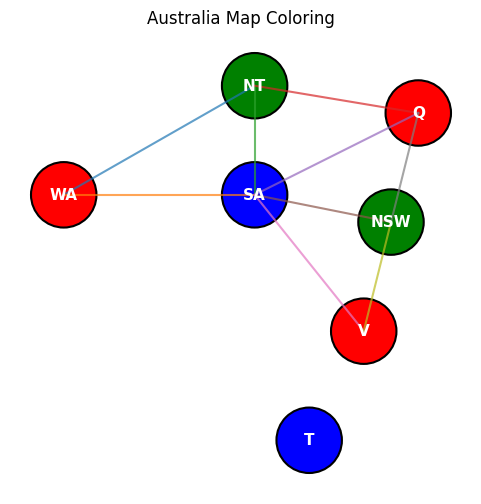

In [3]:
csp = australia_map_coloring()

# EXAMPLE 1: a VALID solution assignment
assignment_valid = {
    "WA":  "red",
    "NT":  "green",
    "SA":  "blue",
    "Q":   "red",
    "NSW": "green",
    "V":   "red",
    "T":   "blue",   # Tasmania is isolated; any color works
}

print("Variables:", csp.variables)
print("Domains:", csp.domains)
print("Neighbors of SA:", csp.neighbors["SA"])

print("Valid?", is_complete_and_valid(csp, assignment_valid))
plot_australia_coloring(assignment_valid)

Let's also check out an invalid assignment:

Valid? False


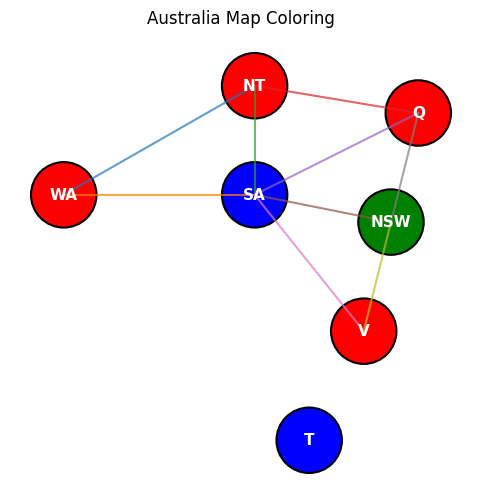

In [4]:
assignment_invalid = {
    "WA":  "red",
    "NT":  "red",    # <-- violates WA–NT ≠ constraint
    "SA":  "blue",
    "Q":   "red",
    "NSW": "green",
    "V":   "red",
    "T":   "blue",
}

print("Valid?", is_complete_and_valid(csp, assignment_invalid))  # should be False
plot_australia_coloring(assignment_invalid)                      # still plots; helps explain violations

### <a name="naive_search"></a> 1A. Naive Search with Variable Ordering (15 points)

Implement a brute-force **depth-first search** (DFS) that:
- assigns variables **in the given order** (`csp.variables`);
- **does not** check constraints until a **full** assignment is reached;
- returns **(solution_dict_or_None, steps_int)**, where **steps** = number of DFS nodes (partial assignments) visited.

<div class="alert alert-info">
Complete the code for `naive_search` below.
</div>

In [117]:
def naive_search(csp: CSP) -> tuple[dict | None, int]:
    """
    Implement a brute-force DFS that:
      - assigns variables in the given order (csp.variables)
      - DOES NOT check constraints until a full assignment is built
      - returns a complete, valid assignment dict if one is found; else None
      - returns how many DFS nodes (partial assignments) were visited

    Returns:
      (solution_dict_or_None, steps_int)
    """
    order = list(csp.variables)
    
    def dfs(i: int, part_assign: dict) -> tuple[dict | None, int]:
        i += 1
        if part_assign is not None and set(part_assign.keys()) == set(csp.variables):
            if is_complete_and_valid(csp, part_assign):
                return part_assign, i

        else: # expand if not complete
            part_assign = dict() if part_assign is None else part_assign
            next_id = len(part_assign)
            next_var = csp.variables[next_id]
            expanded = []
            for domain in csp.domains[next_var]:
                new_node = part_assign.copy()
                new_node.update({next_var:domain})
                expanded.append(new_node)

            for next_node in expanded:
                result = dfs(i, next_node)
                if result[0] is not None:
                    return result
                else:
                    i = result[1]
            return None, i
        return None, i

    return dfs(0, dict())  

Let's now run your implementation of Naive Search on the Australia problem:


Naive search (node count)
--------------------------------------
Valid solution found?: True
Nodes visited (DFS states): 627


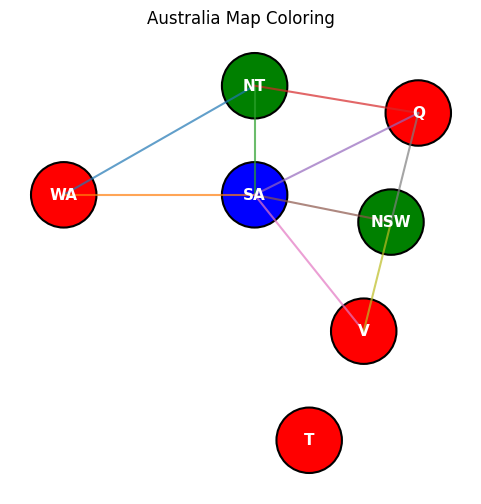

In [118]:
# 1) build the CSP
csp = australia_map_coloring()

# 2) check the solution and counter
solution, steps = naive_search(csp)
print("\nNaive search (node count)")
print("--------------------------------------")
print("Valid solution found?:", solution is not None and is_complete_and_valid(csp, solution))
print("Nodes visited (DFS states):", steps)

# 3) visualize
if solution:
    plot_australia_coloring(solution)

Even on an unsolvable version of the Australia map (2 colors instead of 3), Naive Search is very inefficient: it enumerates all possible colorings before concluding there is no solution.

In [119]:
# 1) build the impossible CSP
csp = australia_map_coloring_impossible()

# 2) check the solution and counter
solution_impossible, steps_impossible = naive_search(csp)
print("\nNaive search (node count)")
print("--------------------------------------")
print("Valid solution found?:", solution_impossible is not None and is_complete_and_valid(csp, solution_impossible))
print("Nodes visited (DFS states):", steps_impossible)


Naive search (node count)
--------------------------------------
Valid solution found?: False
Nodes visited (DFS states): 255


In [120]:
# Test 1
Grader.run_single_test_inline(TestPSet4, "test_01_naive_search", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


### <a name="backtracking_search"></a> 1B. Backtracking Search (10 points)

Implement **backtracking search** that checks constraints **as soon as** you assign a variable (early failure):
- Same fixed order as naive search.
- After tentatively setting `part_assign[var] = val`, call `csp.is_consistent(var, part_assign)`.
- If consistent, recurse; otherwise, **backtrack** immediately.
- Return **(solution_dict_or_None, steps_int)** where **steps** counts DFS nodes like before.

<div class="alert alert-info">
Complete the code for `backtracking_search` below.
</div>

In [121]:
def backtracking_search(csp: CSP) -> tuple[dict | None, int]:
    """
    Implement backtracking search that:
      - assigns variables in the given order (csp.variables)
      - AFTER assigning a variable a value, IMMEDIATELY checks consistency for constraints involving it
      - returns a complete, valid assignment dict if one is found; else None
      - returns how many DFS nodes (partial assignments) were visited

    Returns:
      (solution_dict_or_None, steps_int)
    """
    order = list(csp.variables)

    def dfs(i: int, part_assign: dict) -> tuple[dict | None, int]:
        i += 1
        if part_assign is not None and set(part_assign.keys()) == set(csp.variables):
            if is_complete_and_valid(csp, part_assign):
                return part_assign, i

        else: # expand if not complete
            part_assign = dict() if part_assign is None else part_assign
            next_id = len(part_assign)
            next_var = csp.variables[next_id]
            expanded = []
            for domain in csp.domains[next_var]:
                new_node = part_assign.copy()
                new_node.update({next_var:domain})
                expanded.append(new_node)

            for next_node in expanded: # TODO: Add backtracking here
                if csp.is_consistent(next_var, next_node): # only if consistent then iterate
                    result = dfs(i, next_node)
                    if result[0] is not None:
                        return result
                    else:
                        i = result[1]
            return None, i
        return None, i

    # start the DFS at depth 0 with an empty assignment {}
    return dfs(0, {})

Let's now run your implementation of Backtracking Search on the Australia problem:


Backtracking search
--------------------------------------
Valid solution found?: True
Backtracking solution: {'WA': 'red', 'NT': 'green', 'SA': 'blue', 'Q': 'red', 'NSW': 'green', 'V': 'red', 'T': 'red'}
Nodes visited: 8


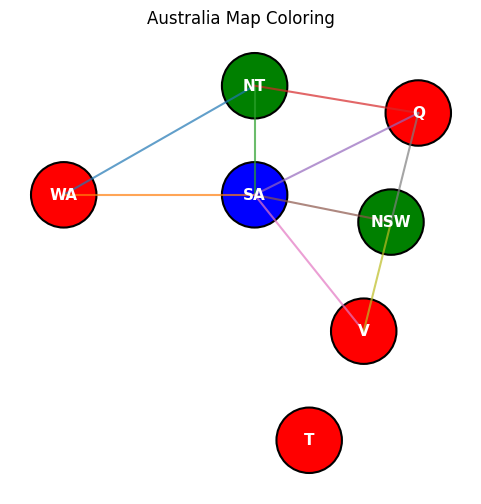

In [122]:
# 1) build the CSP
csp = australia_map_coloring()

# 2) check the solution and counter
solution_bt, steps_bt = backtracking_search(csp)
print("\nBacktracking search")
print("--------------------------------------")
print("Valid solution found?:", solution_bt is not None and is_complete_and_valid(csp, solution_bt))
print("Backtracking solution:", solution_bt)
print("Nodes visited:", steps_bt)

# 3) visualize
if solution_bt:
    plot_australia_coloring(solution_bt)

With this improvement, Backtracking Search is also much quicker at figuring out that a problem is unsolvable compared to Naive Search. By checking constraints as soon as a variable is assigned, it can prune inconsistent branches early.

In [123]:
# 1) build the impossible CSP
csp = australia_map_coloring_impossible()

# 2) check the solution and counter
solution_impossible_bt, steps_impossible_bt = backtracking_search(csp)
print("\Backtracking solution")
print("--------------------------------------")
print("Valid solution found?:", solution_impossible_bt is not None and is_complete_and_valid(csp, solution_impossible_bt))
print("Nodes visited:", steps_impossible_bt)

\Backtracking solution
--------------------------------------
Valid solution found?: False
Nodes visited: 5


In [124]:
# Test 2
Grader.run_single_test_inline(TestPSet4, "test_02_backtracking_search", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


### <a name="forward_checking"></a> 1C. Forward Checking (20 points)

Implement **backtracking search with forward checking**:
- After assigning `var = val`, **prune** inconsistent values from **unassigned neighbors**’ domains.
- If any neighbor’s domain becomes empty, **backtrack** immediately.
- Carefully **restore** pruned values when backtracking.
- Return **(solution_dict_or_None, steps_int)** with the same node counting.

**What to implement**:
- `prune_neighbors(var, val, part_assign)` → returns `{neighbor: [removed_values...]}` or `None` (for wipeout).
- `restore(removed)` → put values back on backtrack.
- The DFS loop that applies + restores pruning.

<div class="alert alert-info">
Complete the code for `forward_checking_search` below.
</div>

In [141]:
def forward_checking_search(csp) -> tuple[dict | None, int]:
    """
    Implement backtracking search + forward checking that:
      - assigns variables in the given order (csp.variables)
      - after assigning var=val, PRUNE neighbors' domains by removing values
        that would violate any binary constraint with var
      - backtrack immediately if any neighbor domain becomes empty
      - restore pruned values on backtrack
      - returns (solution_dict_or_None, steps_int)

    Returns:
      (solution_dict_or_None, steps_int)
    """
    order = list(csp.variables)
    domains = {v: list(csp.domains[v]) for v in order}

    def prune_neighbors(var, val, part_assign) -> dict | None:
        """
        Forward-checking step:
            For each unassigned neighbor 'nbr' of 'var', remove values y in domains[nbr]
            for which some constraint between (var, nbr) would be violated by (var=val, nbr=y).
        Returns:
            - dict {nbr: [removed_values,...]} for restoration, or
            - None if a neighbor's domain becomes empty (wipeout -> immediate failure).
        """
        removed_vals = {}
        part_assign[var] = val  # temporarily assign

        for nbr in csp.neighbors[var]:
            if nbr in part_assign:
                continue
            to_remove = []
            for y in domains[nbr]:
                # Check consistency if nbr = y
                if not all(c.satisfied({**part_assign, nbr: y}) for c in csp.constraints[nbr]):
                    to_remove.append(y)
            if to_remove:
                removed_vals[nbr] = to_remove
                for y in to_remove:
                    domains[nbr].remove(y)
            if not domains[nbr]:  # wipeout
                # Restore any previously removed before returning
                for r_var, r_vals in removed_vals.items():
                    domains[r_var].extend(r_vals)
                return None
        return removed_vals

    def restore(removed):
        """
        Undo forward-checking domain pruning:
            For each variable listed in 'removed', add the pruned values back into its domain
        """
        # raise NotImplementedError()
        if removed:
            for var, vals in removed.items():
                domains[var].extend(vals)

    # TODO: This is the backtracking code, need to update
    def dfs(i: int, part_assign: dict) -> tuple[dict | None, int]:
        # raise NotImplementedError()
        i += 1
        if len(part_assign) == len(csp.variables):
            if is_complete_and_valid(csp, part_assign):
                return part_assign.copy(), i
            else:
                return None, i

        next_var = csp.variables[len(part_assign)]
        for val in list(domains[next_var]):  # iterate over current domain
            if all(c.satisfied({**part_assign, next_var: val}) for c in csp.constraints[next_var]):
                removed = prune_neighbors(next_var, val, part_assign.copy())
                if removed is not None:
                    part_assign[next_var] = val
                    result, i = dfs(i, part_assign)
                    if result is not None:
                        return result, i
                    # backtrack
                    restore(removed)
                    del part_assign[next_var]
        return None, i

    # start the DFS at depth 0 with an empty assignment {}
    return dfs(0, {})


Let's now run your implementation of Backtracking Search with Forward Checking on the Australia problem:

\Forward checking search
--------------------------------------
Valid solution found?: True
Forward checking solution: {'WA': 'red', 'NT': 'green', 'SA': 'blue', 'Q': 'red', 'NSW': 'green', 'V': 'red', 'T': 'red'}
Nodes visited: 8


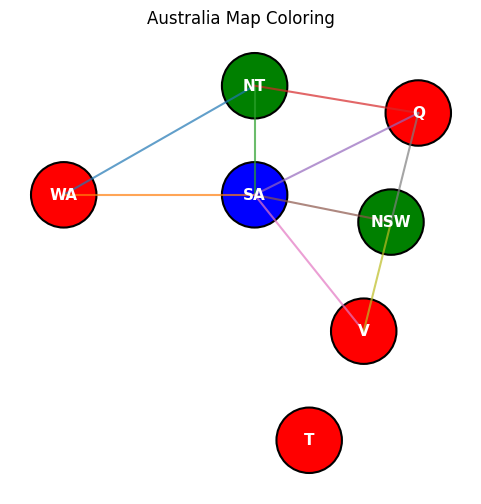

In [142]:
# 1) build the CSP
csp = australia_map_coloring()

# 2) check the solution and counter
solution_fc, steps_fc = forward_checking_search(csp)
print("\Forward checking search")
print("--------------------------------------")
print("Valid solution found?:", solution_fc is not None and is_complete_and_valid(csp, solution_fc))
print("Forward checking solution:", solution_fc)
print("Nodes visited:", steps_fc)

# 3) visualize
if solution_fc:
    plot_australia_coloring(solution_fc)

Forward Checking improves efficiency even further on unsolvable problems. By pruning inconsistent values from the domains of unassigned neighbors, it can detect dead-ends much earlier. This is especially helpful when every path is a dead-end, as it is in an unsolvable problem.

In [143]:
# 1) build the impossible CSP
csp = australia_map_coloring_impossible()

# 2) check the solution and counter
solution_impossible_fc, steps_impossible_fc = forward_checking_search(csp)
print("\Forward checking solution")
print("--------------------------------------")
print("Valid solution found?:", solution_impossible_fc is not None and is_complete_and_valid(csp, solution_impossible_fc))
print("Nodes visited:", steps_impossible_fc)

\Forward checking solution
--------------------------------------
Valid solution found?: False
Nodes visited: 3


In [144]:
# Test 3
Grader.run_single_test_inline(TestPSet4, "test_03_forward_checking", locals())

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### <a name="comparison"></a> 1D. Comparing algorithms on N-Queens (10 points)

Australia has few variables and sparse constraints, so improvements may look mild. N-Queens will help us compare and contrast our algorithms better. Let's create N-Queens and run our 3 algorithms above. Increase `n` gradually (e.g. 6, 8, 10) and note where naive search becomes infeasible.


=== N=6 Queens ===
Naive: steps=15316, valid=True
Backtracking: steps=32, valid=True
Forward Checking: steps=18, valid=True


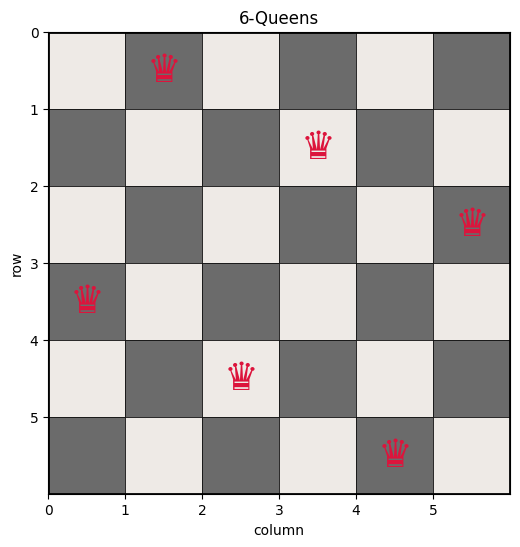

In [146]:
# Build N-Queens instance
n = 6 # Try out a few examples
print(f"\n=== N={n} Queens ===")
csp = n_queens_csp(n)

# Run naive
naive_sol, naive_steps = naive_search(csp)
print(f"Naive: steps={naive_steps}, valid={is_complete_and_valid(csp, naive_sol or {})}")

# Run backtracking
bt_sol, bt_steps = backtracking_search(csp)
print(f"Backtracking: steps={bt_steps}, valid={is_complete_and_valid(csp, bt_sol or {})}")

# Run Forward Checking
fc_sol, fc_steps = forward_checking_search(csp)
print(f"Forward Checking: steps={fc_steps}, valid={is_complete_and_valid(csp, fc_sol or {})}")

# Plot the forward-checking solution (if found)
if fc_sol:
    plot_n_queens(fc_sol, n=n, invert_rows=True)

We can even plot the number of nodes expanded with increasing `n`. Run all three algorithms (naive, backtracking, forward checking) on N-Queens for a range of N values (e.g. 1–8). Plot N vs. nodes visited for each algorithm on the same plot the cell below.

**Hint:** Not seeing a line for Backtracking? It's probably covered by the Forward Checking line - try plotting with a log y-scale!

<Figure size 600x400 with 0 Axes>

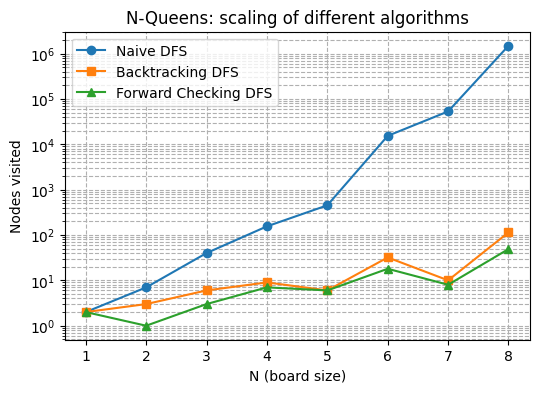

/tmp/ipykernel_19/572521719.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


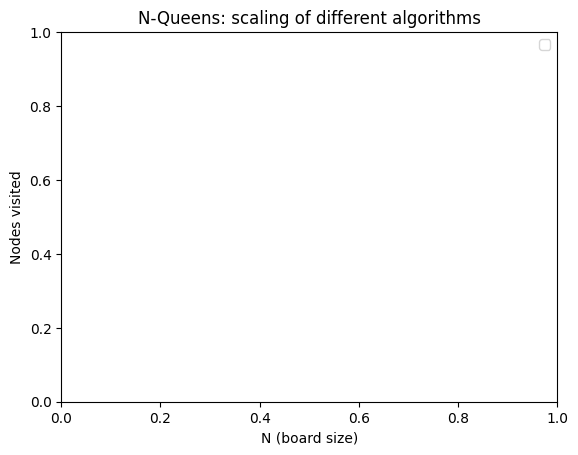

In [221]:
plt.figure(figsize=(6,4))

# Put your plotting code here!
# Range of board sizes
N_values = list(range(1, 9))  # e.g., 1 through 8

# Containers for nodes visited
# naive_nodes = []
# bt_nodes = []
# fc_nodes = []

# for n in N_values:
#     print(f"\n=== N={n} Queens ===")
#     csp = n_queens_csp(n)

#     # Naive DFS
#     naive_sol, naive_steps = naive_search(csp)
#     naive_nodes.append(naive_steps)
#     print(f"Naive: steps={naive_steps}, valid={is_complete_and_valid(csp, naive_sol or {})}")

#     # Backtracking DFS
#     bt_sol, bt_steps = backtracking_search(csp)
#     bt_nodes.append(bt_steps)
#     print(f"Backtracking: steps={bt_steps}, valid={is_complete_and_valid(csp, bt_sol or {})}")

#     # Forward Checking DFS
#     fc_sol, fc_steps = forward_checking_search(csp)
#     fc_nodes.append(fc_steps)
#     print(f"Forward Checking: steps={fc_steps}, valid={is_complete_and_valid(csp, fc_sol or {})}")

N_values = [1,2,3,4,5,6,7,8]

naive_nodes = [2,7,40,155,451,15316,52914,1485549]
bt_nodes    = [2,3,6,9,6,32,10,114]
fc_nodes    = [2,1,3,7,6,18,8,49]

plt.figure(figsize=(6,4))
plt.plot(N_values, naive_nodes, marker='o', label="Naive DFS")
plt.plot(N_values, bt_nodes, marker='s', label="Backtracking DFS")
plt.plot(N_values, fc_nodes, marker='^', label="Forward Checking DFS")
plt.yscale("log")
plt.xlabel("N (board size)")
plt.ylabel("Nodes visited")
plt.title("N-Queens: scaling of different algorithms")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()


plt.xlabel("N (board size)")
plt.ylabel("Nodes visited")
plt.title("N-Queens: scaling of different algorithms")
plt.legend()
plt.savefig("nqueens_scaling.png")
plt.show()

**Now answer the following questions:**
1. How do the curves differ across algorithms? Which one scales worst, and which scales best?  
2. Why does forward checking give larger benefits on N-Queens than on Australia?  

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

1. Predicably, Naive DFS scales the worst (exponential) and DFS with forward checking scales the best (slightly better than backtracking) due to pruning.
2. N-Queens is much more constrained locally compared to Australia, as placing a queen immediately eliminates all the cells in that queen's row and column. In other words, because of the stricter constraints of N-Queens, forward checking prunes the search tree much faster for N-Queens compared to Australia.

## <a name="local_search"></a> 2. Local Search for Constraint Satisfaction Problems (15 points)

### 2A. (5 points)

When there is some kind of information available about the "quality" of a non-satisfying assignment, then we can do local search, trying to improve that solution by making a sequence of small improving changes.

Which of the following might make good measures of the quality of an assignment, which would decrease as the assignment improved toward a solution?

1.  Number of violated constraints
2. Sum of the "amount" each constraint is violated (for example, how much two objects interpenetrate, given a collision-free constraint)
3. Number of values in the domains of the variables involved in violated constraints

In [138]:
## Enter your answer by changing the assignment expression below, e.g., q4_answer = (True, False, True)
## Your answer should be a tuple of 3 True / False values. 
q4_answer = (True, True, False)
# raise NotImplementedError() 

In [139]:
# Test 4
Grader.run_single_test_inline(TestPSet4, "test_04", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### 2B. (5 points)

Consider an algorithm in which you iterate these steps until you find a solution:

- Find a violated constraint.
- Make a minimal reassignment of values to variables involved in it, so that it becomes satisfied.

True or False: Is it guaranteed to find a satisfying assignment if one exists?

In [134]:
## Enter your answer by changing the assignment expression below, e.g., q5_answer = True
q5_answer = False
# raise NotImplementedError() 

In [135]:
# Test 5
Grader.run_single_test_inline(TestPSet4, "test_05", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### 2C. (5 points)

Consider an algorithm in which you iterate these steps until you find a solution:

- Pick a variable at random and a possible assignment to it.
- If changing that variable to have that value decreases the number of constraints that are violated, make the change, otherwise do not.

True or False: Is it guaranteed to find a satisfying assignment if one exists?

In [130]:
## Enter your answer by changing the assignment expression below, e.g., q6_answer = True
q6_answer = False
# raise NotImplementedError() 

In [131]:
# Test 6
Grader.run_single_test_inline(TestPSet4, "test_06", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### 2D. (5 points)

Consider an algoirthm in which you iterate these steps until you find a solution:

- Pick a variable at random and a possible assignment to it.
- If changing that variable to have that value improves the quality of the assignment, make the change.
- Otherwise, with probability $e^{-\delta / T}$ where $\delta$ is the change in assignment quality, accept the change

True or False: Is there a way to manage the $T$ parameter so this is guaranteed to find a satisfying assignment if one exists?

In [147]:
## Enter your answer by changing the assignment expression below, e.g., q7_answer = True
q7_answer = True
# raise NotImplementedError() 

In [148]:
# Test 7
Grader.run_single_test_inline(TestPSet4, "test_07", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


## 3. <a name="classical_planning"></a> Classical Planning (25 points) 

In this section, we shift to **classical planning**. You will get hands-on practice with running a planner on simple problems, writing your own PDDL domain and problem, and comparing heuristics and search strategies.

As before, we'll scaffold most of the setup so you can focus on the core planning ideas:


In [150]:
import os
import time
import tempfile
from pyperplan.pddl.parser import Parser
from pyperplan import grounding, planner

# This uses TYPING
BLOCKS_DOMAIN = """(define (domain blocks)
    (:requirements :strips :typing)
    (:types block)
    (:predicates
        (on ?x - block ?y - block)
        (ontable ?x - block)
        (clear ?x - block)
        (handempty)
        (holding ?x - block)
    )

    (:action pick-up
        :parameters (?x - block)
        :precondition (and
            (clear ?x)
            (ontable ?x)
            (handempty)
        )
        :effect (and
            (not (ontable ?x))
            (not (clear ?x))
            (not (handempty))
            (holding ?x)
        )
    )

    (:action put-down
        :parameters (?x - block)
        :precondition (and
            (holding ?x)
        )
        :effect (and
            (not (holding ?x))
            (clear ?x)
            (handempty)
            (ontable ?x))
        )

    (:action stack
        :parameters (?x - block ?y - block)
        :precondition (and
            (holding ?x)
            (clear ?y)
        )
        :effect (and
            (not (holding ?x))
            (not (clear ?y))
            (clear ?x)
            (handempty)
            (on ?x ?y)
        )
    )

    (:action unstack
        :parameters (?x - block ?y - block)
        :precondition (and
            (on ?x ?y)
            (clear ?x)
            (handempty)
        )
        :effect (and
            (holding ?x)
            (clear ?y)
            (not (clear ?x))
            (not (handempty))
            (not (on ?x ?y))
        )
    )
)
"""

# This uses TYPING
BLOCKS_PROBLEM = """(define (problem blocks)
    (:domain blocks)
    (:objects
        d - block
        b - block
        a - block
        c - block
    )
    (:init
        (clear a)
        (on a b)
        (on b c)
        (on c d)
        (ontable d)
        (handempty)
    )
    (:goal (and (on d c) (on c b) (on b a)))
)
"""

# The BW domain does not use TYPING
BW_BLOCKS_DOMAIN = """(define (domain prodigy-bw)
  (:requirements :strips)
  (:predicates (on ?x ?y)
               (ontable ?x)
               (clear ?x)
               (handempty)
               (holding ?x)
               )
  (:action pick-up
             :parameters (?ob1)
             :precondition (and (clear ?ob1) (ontable ?ob1) (handempty))
             :effect
             (and (not (ontable ?ob1))
                   (not (clear ?ob1))
                   (not (handempty))
                   (holding ?ob1)))
  (:action put-down
             :parameters (?ob)
             :precondition (holding ?ob)
             :effect
             (and (not (holding ?ob))
                   (clear ?ob)
                   (handempty)
                   (ontable ?ob)))
  (:action stack
             :parameters (?sob ?sunderob)
             :precondition (and (holding ?sob) (clear ?sunderob))
             :effect
             (and (not (holding ?sob))
                   (not (clear ?sunderob))
                   (clear ?sob)
                   (handempty)
                   (on ?sob ?sunderob)))
  (:action unstack
             :parameters (?sob ?sunderob)
             :precondition (and (on ?sob ?sunderob) (clear ?sob) (handempty))
             :effect
             (and (holding ?sob)
                   (clear ?sunderob)
                   (not (clear ?sob))
                   (not (handempty))
                   (not (on ?sob ?sunderob)))))
"""


def get_task_definition_str(domain_pddl_str, problem_pddl_str):
    """Get Pyperplan task definition from PDDL domain and problem.

    This function is a lightweight wrapper around Pyperplan.

    Args:
      domain_pddl_str: A str, the contents of a domain.pddl file.
      problem_pddl_str: A str, the contents of a problem.pddl file.

    Returns:
      task: a structure defining the problem
    """
    # Parsing the PDDL
    domain_file = tempfile.NamedTemporaryFile(delete=False)
    problem_file = tempfile.NamedTemporaryFile(delete=False)
    with open(domain_file.name, 'w') as f:
        f.write(domain_pddl_str)
    with open(problem_file.name, 'w') as f:
        f.write(problem_pddl_str)
    parser = Parser(domain_file.name, problem_file.name)
    domain = parser.parse_domain()
    problem = parser.parse_problem(domain)
    os.remove(domain_file.name)
    os.remove(problem_file.name)

    # Ground the PDDL
    task = grounding.ground(problem)
    return task


def run_planning(domain_pddl_str,
                 problem_pddl_str,
                 search_alg_name,
                 heuristic_name=None,
                 return_time=False):
    """Plan a sequence of actions to solve the given PDDL problem.

    This function is a lightweight wrapper around pyperplan.

    Args:
      domain_pddl_str: A str, the contents of a domain.pddl file.
      problem_pddl_str: A str, the contents of a problem.pddl file.
      search_alg_name: A str, the name of a search algorithm in
        pyperplan. Options: astar, wastar, gbf, bfs, ehs, ids, sat.
      heuristic_name: A str, the name of a heuristic in pyperplan.
        Options: blind, hadd, hmax, hsa, hff, lmcut, landmark.
      return_time:  Bool. Set to `True` to return the planning time.

    Returns:
      plan: A list of actions; each action is a pyperplan Operator.
    """
    # Ground the PDDL
    task = get_task_definition_str(domain_pddl_str, problem_pddl_str)

    # Get the search alg
    search_alg = planner.SEARCHES[search_alg_name]

    if heuristic_name is None:
        if not return_time:
            return search_alg(task)
        start_time = time.time()
        plan = search_alg(task)
        plan_time = time.time() - start_time
        return plan, plan_time

    # Get the heuristic
    heuristic = planner.HEURISTICS[heuristic_name](task)

    # Run planning
    start_time = time.time()
    plan = search_alg(task, heuristic)
    plan_time = time.time() - start_time

    if return_time:
        return plan, plan_time
    return plan


def h_add_test(prob_str, expected_h):
    task = get_task_definition_str(BW_BLOCKS_DOMAIN, prob_str)
    h = h_add(task)
    assert h == expected_h, f"Expected h={expected_h}, but got {h}."
    return h


def h_ff_test(prob_str, expected_h):
    task = get_task_definition_str(BW_BLOCKS_DOMAIN, prob_str)
    h = h_ff(task)
    assert h == expected_h, f"Expected h={expected_h}, but got {h}."

### <a name="warmup"></a> 3A. Warming up with Pyperplan (5 points)

In this homework, we will be using a Python PDDL planner called `pyperplan`. Let's warm up by using `pyperplan` to solve a given blocks PDDL problem.

Use `run_planning` to find a plan for the blocks problem defined above (`BLOCKS_DOMAIN`, `BLOCKS_PROBLEM`).

The `run_planning` function takes in a PDDL domain string, a PDDL problem string, the name of a search algorithm, and the name of a heuristic (if the search algorithm is informed) or a customized heuristic class. It then uses the Python planning library `pyperplan` to find a plan.

The plan returned by `run_planning` is a list of pyperplan Operators. You should not need to manipulate these data structures directly in this homework, but if you are curious about the definition, see [here](https://github.com/aibasel/pyperplan/blob/master/pyperplan/task.py#L23).

The search algs available in pyperplan are: `astar, wastar, gbf, bfs, ehs, ids, sat`. The heuristics available in pyperplan are: `blind, hadd, hmax, hsa, hff, lmcut, landmark`.

For this question, use the `astar` search algorithm with the `hadd` heuristic.

For reference, our solution is **1** line(s) of code.


In [153]:
def planning_warmup():
    '''Use run_planning to find a plan for the blocks problem defined at the
    top of the colab file (BLOCKS_DOMAIN, BLOCKS_PROBLEM).

      Use the astar search algorithm with the hadd heuristic.

    Returns:
      plan: A list of actions; each action is a pyperplan Operator.
    '''
    return run_planning(BLOCKS_DOMAIN, BLOCKS_PROBLEM, "astar", "hadd")


In [154]:
# Test 8
Grader.run_single_test_inline(TestPSet4, "test_08_planning_warmup", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.021s

OK


### <a name="pddl"></a> 3B. Fill in the Blanks (10 points)

You've received PDDL domain and problem strings from your boss and you need to make a plan, pronto! Unfortunately, some of the PDDL is missing.

Here's what you know. What you're trying to model is a newspaper delivery robot. The robot starts out at a "home base" where there are papers that it can pick up. The robot can hold arbitrarily many papers at once. It can then move around to different locations and deliver papers.

Not all locations want a paper -- the goal is to satisfy all the locations that do want a paper.

You also know:
* There are 6 locations in addition to 1 for the homebase. Locations 1, 2, 3, and 4 want paper; locations 5 and 6 do not.
* There are 8 papers at the homebase.
* The robot is initially at the homebase with no papers packed.

Use this description to complete the PDDL domain and problem. You can assume the PDDL planner will find the optimal solution.

If you are running into issues writing or debugging the PDDL you can check out this online PDDL editor, which comes with a built-in planner: [editor.planning.domains](http://editor.planning.domains). To use the editor, you can create two files, one for the domain and one for the problem. You can then click "Solve" at the top to use the built-in planner.

For a general reference on PDDL, check out [planning.wiki](https://planning.wiki/). Note that the PDDL features supported by pyperplan are very limited: types and constants are supported, but that's about it. If you want to make a domain that involves more advanced features, you can try the built-in planner at [editor.planning.domains](http://editor.planning.domains), or you can use any other PDDL planner of your choosing.

Debugging PDDL can be painful. The online editor at [editor.planning.domains](http://editor.planning.domains) is helpful: pay attention to the syntax highlighting and to the line numbers in error messages that result from trying to Solve. To debug, you can also comment out multiple lines of your files by highlighting and using `Ctrl + /` or `Cmd + /`. Common issues to watch out for include:
* A predicate is not defined in the domain file
* A variable name does not start with a question mark
* An illegal character is used (we recommended sticking with alphanumeric characters, dashes, or underscores; and don't start any names with numbers)
* An operator is missing a parameter (in general, the parameters should be exactly the variables that are used anywhere in the operator's preconditions or effects)
* An operator is missing a necessary precondition or effect
* Using negated preconditions, which are not allowed in basic Strips

If you get stuck debugging your PDDL file for more than 10-15 min, please reach out and we'll help!

Look through the following file, find the TODOs and complete the necessary PDDL terms. 

In [155]:
def pddl_warmup():
    '''Creates a PDDL domain and problem strs for newspaper delivery (uses
    TYPING).

    Returns:
      domain: str
      problem: str
    '''
    domain_str = '''(define (domain newspapers)
    (:requirements :strips :typing)
    (:types loc paper)
    (:predicates
      (at ?loc - loc)
      (isHomeBase ?loc - loc)
      (unpacked ?paper - paper)
      (carrying ?paper - paper)
      (satisfied ?loc - loc)
    )

    (:action pick-up
      :parameters (?paper - paper ?loc - loc)
      :precondition (and
        (at ?loc)
        (isHomeBase ?loc)
        (unpacked ?paper)
      )
      :effect (and
        (not (unpacked ?paper))
        (carrying ?paper)
      )
    )

    (:action move
      :parameters (?from - loc ?to - loc)
      :precondition (and
        (at ?from) 
      )
      :effect (and
        (not (at ?from))
        (at ?to)
      )
    )

    (:action deliver
      :parameters (?paper - paper ?loc - loc)
      :precondition (and
        (at ?loc)
        (carrying ?paper)
      )
      :effect (and
        (not (carrying ?paper))
        (satisfied ?loc)
      )
    )

)'''

    problem_str = '''(define (problem newspapers1) (:domain newspapers)
  (:objects
    loc-0 - loc
    loc-1 - loc
    loc-2 - loc
    loc-3 - loc
    loc-4 - loc
    loc-5 - loc
    loc-6 - loc
    paper-0 - paper
    paper-1 - paper
    paper-2 - paper
    paper-3 - paper
    paper-4 - paper
    paper-5 - paper
    paper-6 - paper
    paper-7 - paper
  )
  (:init 
    (at loc-0)
    (isHomeBase loc-0)
    (unpacked paper-0)
    (unpacked paper-1)
    (unpacked paper-2)
    (unpacked paper-3)
    (unpacked paper-4)
    (unpacked paper-5)
    (unpacked paper-6)
    (unpacked paper-7)
  )
  (:goal (and
    (satisfied loc-1)
    (satisfied loc-2)
    (satisfied loc-3)
    (satisfied loc-4)
  ))
)'''

    return domain_str, problem_str


In [156]:
# Test 9
Grader.run_single_test_inline(TestPSet4, "test_09_pddl_warmup", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.120s

OK


### <a name="heuristics"></a> 3C. Planning Heuristics (10 points)

Let's now compare different search algorithms and heuristics.

Let's consider two of the search algorithms available in pyperplan:
`astar, gbf`.

And the following heuristics: `blind, hadd, hmax, hff, lmcut`. `blind`, `hmax` and `lmcut` are admissible; `hadd` and `hff` are not.

Unfortunately the documentation for pyperplan is limited at the moment, but if you
are curious to learn more about its internals, the code is open-sourced on [this GitHub repo](https://github.com/aibasel/pyperplan).

We have given you a set of blocks planning problem of different complexity `BW_BLOCKS_PROBLEM_1` to `BW_BLOCKS_PROBLEM_6`.
You can use the function `test_run_planning` to test the different combinations of search and heuristic
on different problems. There is also a helper function  to plot the result.

If planning takes more than 30 seconds, just kill the process.

In [158]:
BW_BLOCKS_PROBLEM_1 = """(define (problem bw-simple)
  (:domain prodigy-bw)
  (:objects A B C)
  (:init (clear a) (handempty) (on a b) (ontable b))
  (:goal (and (ontable a) (clear b))))
"""

BW_BLOCKS_PROBLEM_2 = """(define (problem bw-sussman)
  (:domain prodigy-bw)
  (:objects A B C)
  (:init (ontable a) (ontable b) (on c a)
                (clear b) (clear c) (handempty))
  (:goal (and (on a b) (on b c))))
"""

BW_BLOCKS_PROBLEM_3 = """(define (problem bw-large-a)
  (:domain prodigy-bw)
  (:objects 1 2 3 4 5 6 7 8 9)
  (:init (handempty)
         (on 3 2)
         (on 2 1)
         (ontable 1)
         (on 5 4)
         (ontable 4)
         (on 9 8)
         (on 8 7)
         (on 7 6)
         (ontable 6)
         (clear 3)
         (clear 5)
         (clear 9))
  (:goal (and
          (on 1 5)
          (ontable 5)
          (on 8 9)
          (on 9 4)
          (ontable 4)
          (on 2 3)
          (on 3 7)
          (on 7 6)
          (ontable 6)
          (clear 1)
          (clear 8)
          (clear 2)
          )))
"""

BW_BLOCKS_PROBLEM_4 = """(define (problem bw-large-b)
  (:domain prodigy-bw)
  (:objects 1 2 3 4 5 6 7 8 9 10 11)
  (:init (handempty)
         (on 3 2)
         (on 2 1)
         (ontable 1)
         (on 11 10)
         (on 10 5)
         (on 5 4)
         (ontable 4)
         (on 9 8)
         (on 8 7)
         (on 7 6)
         (ontable 6)
         (clear 3)
         (clear 11)
         (clear 9))
  (:goal (and
          (on 1 5)
          (on 5 10)
          (ontable 10)
          (on 8 9)
          (on 9 4)
          (ontable 4)
          (on 2 3)
          (on 3 11)
          (on 11 7)
          (on 7 6)
          (ontable 6)
          (clear 1)
          (clear 8)
          (clear 2)
          )))
"""

BW_BLOCKS_PROBLEM_5 = """(define (problem bw-large-c)
  (:domain prodigy-bw)
  (:objects 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15)
  (:init (handempty)
         (on 3 2)
         (on 2 1)
         (on 1 12)
         (on 12 13)
         (ontable 13)
         (on 11 10)
         (on 10 5)
         (on 5 4)
         (on 4 14)
         (on 14 15)
         (ontable 15)
         (on 9 8)
         (on 8 7)
         (on 7 6)
         (ontable 6)
         (clear 3)
         (clear 11)
         (clear 9))
  (:goal (and
          (on 14 1)
          (on 1 5)
          (on 5 10)
          (ontable 10)
          (on 15 13)
          (on 13 8)
          (on 8 9)
          (on 9 4)
          (ontable 4)
          (on 12 2)
          (on 2 3)
          (on 3 11)
          (on 11 7)
          (on 7 6)
          (ontable 6)
          (clear 14)
          (clear 15)
          (clear 12)
          )))

"""

BW_BLOCKS_PROBLEM_6 = """(define (problem bw-large-d)
  (:domain prodigy-bw)
  (:objects 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19)
  (:init (handempty)
         (on 1 12)
         (on 12 13)
         (ontable 13)
         (on 11 10)
         (on 10 5)
         (on 5 4)
         (on 4 14)
         (on 14 15)
         (ontable 15)
         (on 9 8)
         (on 8 7)
         (on 7 6)
         (ontable 6)
         (on 19 18)
         (on 18 17)
         (on 17 16)
         (on 16 3)
         (on 3 2)
         (ontable 2)
         (clear 1)
         (clear 11)
         (clear 9)
         (clear 19))
  (:goal (and
          (on 17 18)
          (on 18 19)
          (on 19 14)
          (on 14 1)
          (on 1 5)
          (on 5 10)
          (ontable 10)
          (on 15 13)
          (on 13 8)
          (on 8 9)
          (on 9 4)
          (ontable 4)
          (on 12 2)
          (on 2 3)
          (on 3 16)
          (on 16 11)
          (on 11 7)
          (on 7 6)
          (ontable 6)
          (clear 17)
          (clear 15)
          (clear 12)
          )))
"""
BW_BLOCKS_PROBLEMS = [
    BW_BLOCKS_PROBLEM_1, BW_BLOCKS_PROBLEM_2, BW_BLOCKS_PROBLEM_3,
    BW_BLOCKS_PROBLEM_4, BW_BLOCKS_PROBLEM_5, BW_BLOCKS_PROBLEM_6
]

We have created some helper functions to plot the running time and plan length of certain search algorithms and heuristics. You can use the `test_all_combinations` function in the following code block to get the planning results.

problem_1 gbf blind
INFO:root:Relevance analysis removed 0 facts
INFO:root:Initial h value: 1.000000
INFO:root:Goal reached. Start extraction of solution.
INFO:root:3 Nodes expanded
Run time	 0.0046	 Plan length	 2

problem_1 gbf hmax
INFO:root:Relevance analysis removed 0 facts
INFO:root:Initial h value: 2.000000
INFO:root:Goal reached. Start extraction of solution.
INFO:root:3 Nodes expanded
Run time	 0.0045	 Plan length	 2

problem_1 gbf hadd
INFO:root:Relevance analysis removed 0 facts
INFO:root:Initial h value: 3.000000
INFO:root:Goal reached. Start extraction of solution.
INFO:root:3 Nodes expanded
Run time	 0.0040	 Plan length	 2

problem_1 gbf hff
INFO:root:Relevance analysis removed 0 facts
INFO:root:Initial h value: 2.000000
INFO:root:Goal reached. Start extraction of solution.
INFO:root:3 Nodes expanded
Run time	 0.0043	 Plan length	 2

problem_1 gbf lmcut
INFO:root:Relevance analysis removed 0 facts
INFO:root:Initial h value: 2.000000
INFO:root:Goal reached. Start extractio

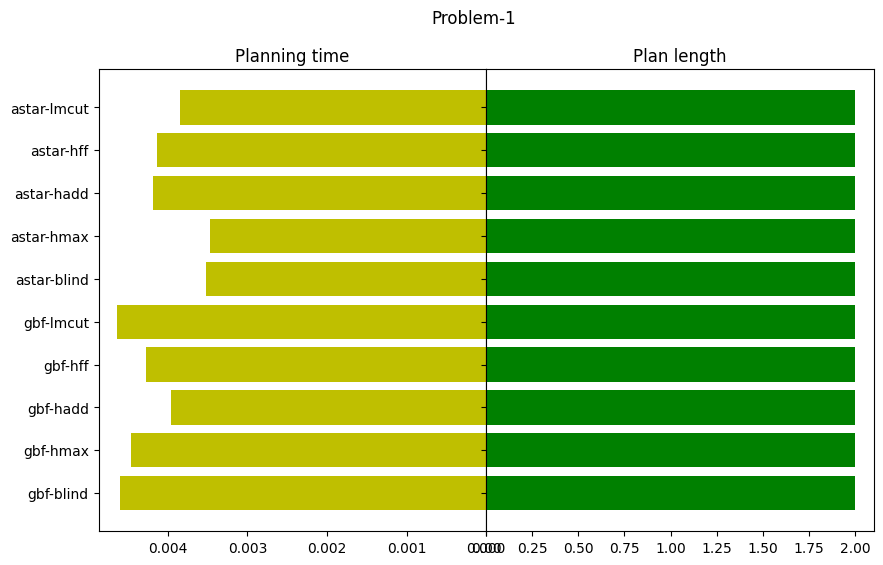

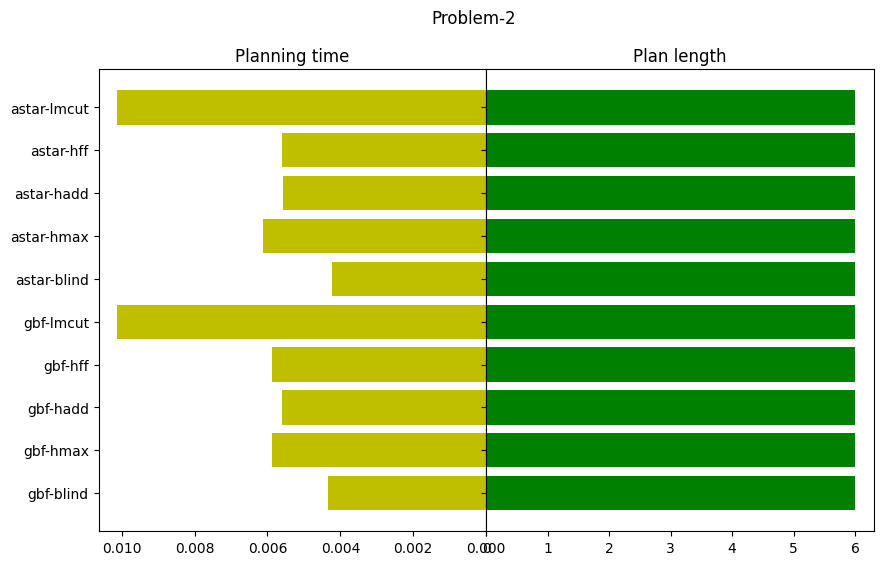

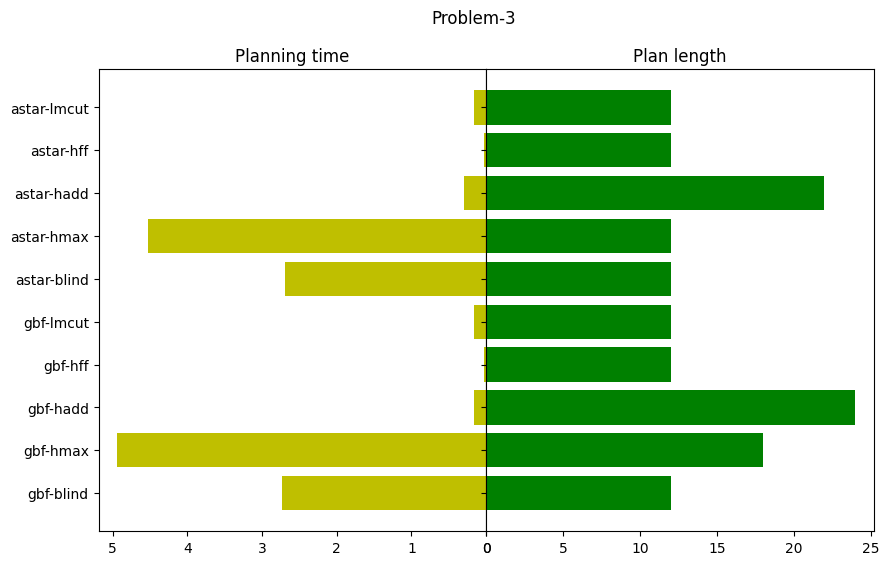

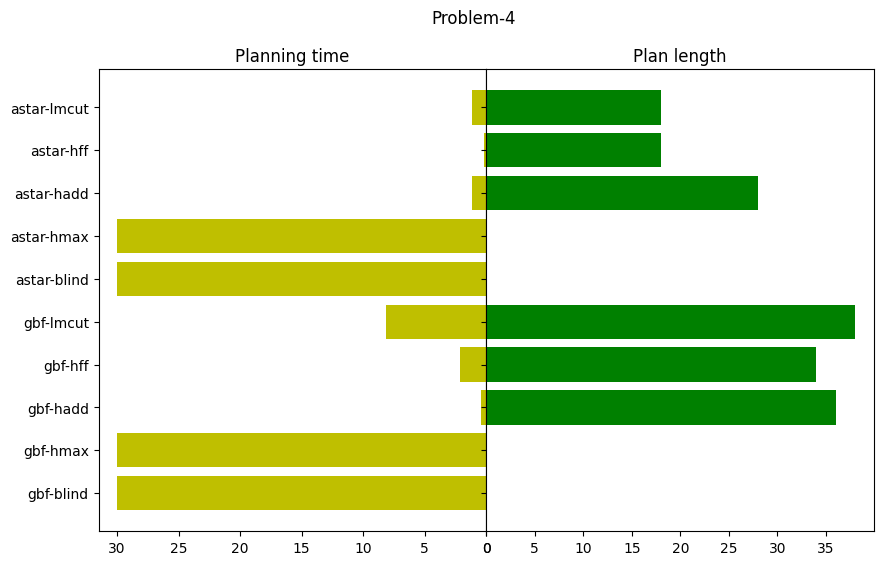

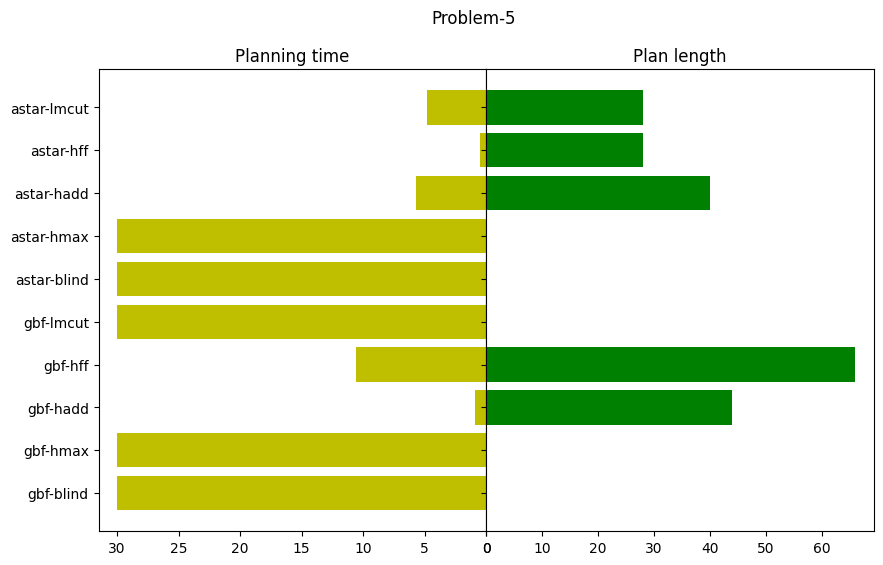

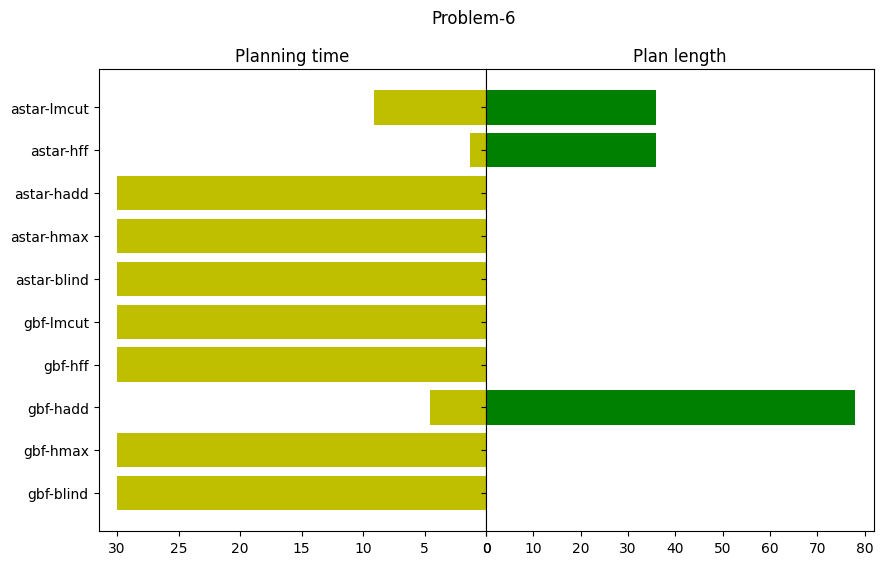

<module 'logging' from '/usr/lib/python3.10/logging/__init__.py'>

In [172]:
import itertools, sys, logging, importlib


def test_run_planning(domain_pddl_str,
                      problem_pddl_id,
                      search_alg_name,
                      heuristic_name,
                      save_dict=None):
    plan, run_time = run_planning(domain_pddl_str,
                                  BW_BLOCKS_PROBLEMS[problem_pddl_id - 1],
                                  search_alg_name,
                                  heuristic_name,
                                  return_time=True)
    print(f'Run time\t {run_time:.4f}\t Plan length\t {len(plan)}')
    save_dict[(search_alg_name, heuristic_name,
               problem_pddl_id)] = [run_time, len(plan)]
    return len(plan), run_time


def plot_result(result, timeout):
    import matplotlib.pyplot as plt
    all_problem_keys = result.keys()
    for problem_id in range(1, 7):
        problem_keys = [k for k in all_problem_keys if k[2] == problem_id]
        problem_keys_str = list(map(lambda x: f'{x[0]}-{x[1]}', problem_keys))
        bb = [
            result[k][0] if result[k][0] != -1 else timeout
            for k in problem_keys
        ]
        cc = [result[k][1] if result[k][0] != -1 else 0 for k in problem_keys]
        fig, axes = plt.subplots(figsize=(10, 6), ncols=2, sharey=True)
        axes[0].barh(problem_keys_str, bb, align='center', color='y')
        axes[1].barh(problem_keys_str, cc, align='center', color='g')
        axes[0].invert_xaxis()
        plt.subplots_adjust(wspace=0)

        axes[0].set(title='Planning time')
        axes[1].set(title='Plan length')
        fig.suptitle(f'Problem-{problem_id}')
        plt.show()


def test_all_combinations(timeout=5):
    import multiprocess as mp
    importlib.reload(logging)
    logging.basicConfig(level=logging.INFO,
                        handlers=[logging.StreamHandler(sys.stdout)])
    problem_id = [i for i in range(1, 7)]
    all_searchalgs = ['gbf', 'astar']
    all_heuristics = ['blind', 'hmax', 'hadd', 'hff', 'lmcut']
    result = {
        (j, k, i): [-1, -1]
        for (i, j,
             k) in itertools.product(problem_id, all_searchalgs, all_heuristics)
    }
    result_savers = []
    with mp.Manager() as manager:
        for problem_i, search_algo, heuristic in itertools.product(
                problem_id, all_searchalgs, all_heuristics):
            print(f'problem_{problem_i}', search_algo, heuristic)
            result_saver = manager.dict()
            result_savers.append(result_saver)
            planning_proc = mp.Process(target=test_run_planning,
                                       args=(BW_BLOCKS_DOMAIN, problem_i,
                                             search_algo, heuristic,
                                             result_saver))
            planning_proc.start()
            planning_proc.join(timeout=timeout)
            if planning_proc.is_alive():
                planning_proc.terminate()
                print(f'Terminate after {timeout} sec.')
                print()
                continue
            print()
        for res in result_savers:
            result.update(res)
    plot_result(result, timeout)


# Uncomment the following line, set timeout limit to plot results
test_all_combinations(timeout=30)
importlib.reload(logging)

Please identify which of these statement are True or False: 

1. Problems 1, 2 and 3 are easy (plan in less than 30 seconds) for all the methods.
2. Problem 4 is easy (plan in less than 30 seconds) for all the non-blind heuristics.
3. Problem 4 is easy (plan in less than 30 seconds) for all the non-blind heuristics, except `hmax`.
4. The `blind` heuristic is generally hopeless for the bigger problems.
5. `hadd` is generally much better (leads to faster planning) than `hmax`.
6. `gbf-lmcut` will always find paths of the same length as `astar-lmcut` (given sufficient time).
7. `astar-lmcut` will always find paths of the same length as `astar-hmax` (given sufficient time).
8. `astar-lmcut` usually finds paths of the same length as `astar-hff` (in these problems).
9. `gbf-hff` is a good compromise for planning speed and plan length (in these problems).

In [217]:
## Enter your answer by changing the assignment expression below, e.g., q10_answer = (True, False, True, ...)
## Your answer should be a tuple of 9 True / False values. 
q10_answer = (
    True, # True: Problems 1, 2 and 3 are easy (plan in less than 30 seconds) for all the methods
    False, # False: Problem 4 is easy (plan in less than 30 seconds) for all the non-blind heuristics.
    True, # Problem 4 is easy (plan in less than 30 seconds) for all the non-blind heuristics, except hmax.
    True, # The blind heuristic is generally hopeless for the bigger problems.
    True, # Could be false: hadd is generally much better (leads to faster planning) than hmax.
    False, # gbf-lmcut will always find paths of the same length as astar-lmcut (given sufficient time)
    True, # astar-lmcut will always find paths of the same length as astar-hmax (given sufficient time).
    True, # astar-lmcut usually finds paths of the same length as astar-hff (in these problems).
    True # gbf-hff is a good compromise for planning speed and plan length (in these problems).
)

In [218]:
# Test 10
Grader.run_single_test_inline(TestPSet4, "test_10", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.009s

OK


# <a name="part4"></a> Time Spent on Pset (5 points)

Please use [this form](https://forms.gle/NXSutgpy3fEtJ8Sw9) to tell us how long you spent on this pset. After you submit the form, the form will give you a confirmation word. Please enter that confirmation word below to get an extra 5 points. 

In [222]:
form_confirmation_word = "Dunkin Donuts"

In [223]:
# Run all tests
Grader.grade_output([TestPSet4], [locals()], "results.json")
Grader.print_test_results("results.json")

Test passed!!

Test passed!!

Test passed!!

Test passed!!

Test passed!!

Test passed!!

Test passed!!

Test passed!!

Test passed!!

Total score is 95/95.

Score for test_01_naive_search (principles_of_autonomy.notebook_tests.pset_4.TestPSet4) is 15/15.

Score for test_02_backtracking_search (principles_of_autonomy.notebook_tests.pset_4.TestPSet4) is 10/10.

Score for test_03_forward_checking (principles_of_autonomy.notebook_tests.pset_4.TestPSet4) is 20/20.

Score for test_04 (principles_of_autonomy.notebook_tests.pset_4.TestPSet4) is 5/5.

Score for test_05 (principles_of_autonomy.notebook_tests.pset_4.TestPSet4) is 5/5.

Score for test_06 (principles_of_autonomy.notebook_tests.pset_4.TestPSet4) is 5/5.

Score for test_07 (principles_of_autonomy.notebook_tests.pset_4.TestPSet4) is 5/5.

Score for test_08_planning_warmup (principles_of_autonomy.notebook_tests.pset_4.TestPSet4) is 5/5.

Score for test_09_pddl_warmup (principles_of_autonomy.notebook_tests.pset_4.TestPSet4) is 10/10.

Score for test_10 (principles_of_autonomy.notebook_tests.pset_4.TestPSet4) is 10/10.

Score for test_11_form_word (principles_of_autono

In [224]:
# Make sure you save the notebook before running this cell so that the most updated version is zipped!
Grader.prepare_submission("ProblemSet04_CSPs_Classical_Planning_release")

Open-ended responses written to ProblemSet04_CSPs_Classical_Planning_release_responses_only.ipynb
Compressed files in folder to ../ps4/ps4.zip (submit this to Gradescope)
